# Good Seed Age Verification System

Good Seed, a supermarket franchise, is committed to complying with age-restriction laws by ensuring that restricted products are not sold to underage customers. To achieve this, the company is developing a system that uses computer vision technology to estimate a person's age from cashier-area camera footage. This system will help identify potential violations by raising alerts when restricted products are purchased by individuals who appear to be underage.

My role in this project is to design, train, and evaluate a convolutional neural network (CNN) model capable of predicting a person’s age from a set of photographs. This involves conducting exploratory data analysis to understand the dataset, preparing the data for model training, and implementing the model using GPU resources to handle computational demands. The goal is to create a highly accurate age prediction system with a mean absolute error (MAE) of no more than 8 on the test set, while aiming for industry-leading performance. Through this work, I aim to support Good Seed in meeting regulatory requirements and improving operational compliance.

## Initialization 

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Import Data

The dataset you need is stored in the folder `/datasets/faces/`. In this folder, you can find:

- The final_file folder with 7.6 thousand photos.
- The labels.csv file that contains labels with two columns: `file_name` and `real_age`.

Considering the significant number of image files, it is advisable not to read them all at once, as it can consume a lot of computational resources. We recommend creating a generator with ImageDataGenerator. This method has been explained in Chapter 3, Lesson 7.

The label file can be loaded as a regular CSV file.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
print(labels.head())

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


In [3]:
train_datagen = ImageDataGenerator(rescale=1/255)

train_datagen_flow = train_datagen.flow_from_dataframe(
dataframe=labels,
directory='/datasets/faces/final_files/',
x_col='file_name',
y_col='real_age',
target_size=(224, 224),
batch_size=32,
class_mode='raw',
seed=1234)

Found 7591 validated image filenames.


In [4]:
features, target = next(train_datagen_flow)

In [5]:
features.shape

(32, 224, 224, 3)

In [6]:
target

array([ 2, 28, 28, 55, 32, 36, 38, 65, 10, 32, 27, 21, 23, 15, 35, 67,  1,
       32, 19, 25,  5, 49, 24, 24, 27, 76, 10,  3, 22, 26, 19, 22])

## EDA

In [7]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [8]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Dataset Size: 7591 rows, 2 columns


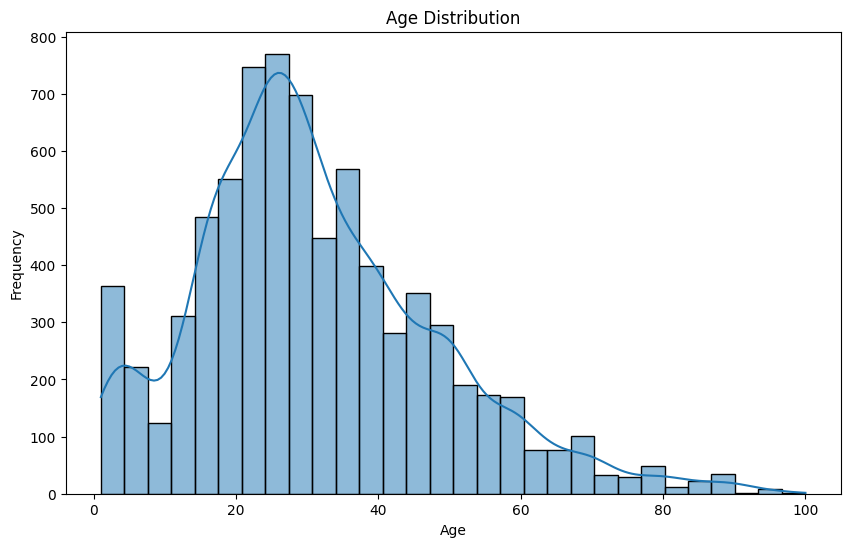

In [9]:
print(f'Dataset Size: {labels.shape[0]} rows, {labels.shape[1]} columns')

plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Found 7591 validated image filenames.


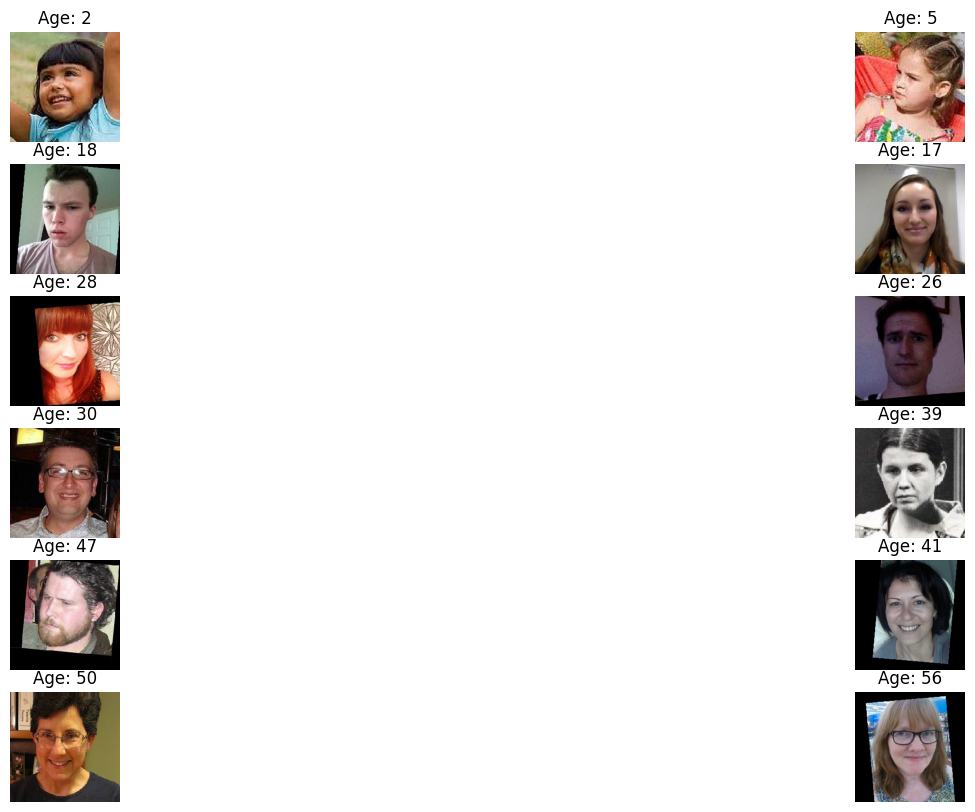

In [11]:
image_folder_path = '/datasets/faces/final_files/'

datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory=image_folder_path,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

def show_images(generator, age_ranges, n_images=2):
    plt.figure(figsize=(20, 10))
    total_images = len(age_ranges) * n_images
    for idx, age_range in enumerate(age_ranges):
        count = 0
        for images, ages in generator:
            for img, age in zip(images, ages):
                if age_range[0] <= age < age_range[1]:
                    count += 1
                    plt.subplot(len(age_ranges), n_images, idx * n_images + count)
                    plt.imshow(img)
                    plt.title(f'Age: {int(age)}')
                    plt.axis('off')
                    if count == n_images:
                        break
            if count == n_images:
                break

age_ranges = [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 60)]
show_images(generator, age_ranges)
plt.show()

In [12]:
count_age = labels['real_age'].value_counts().reset_index()
count_age.rename(columns={'index':'age', 'real_age':'counts'}, inplace=True)

In [13]:
count_age.head()

,age,counts
0,30,317
1,25,315
2,27,229
3,26,226
4,28,217


<AxesSubplot:xlabel='age', ylabel='counts'>

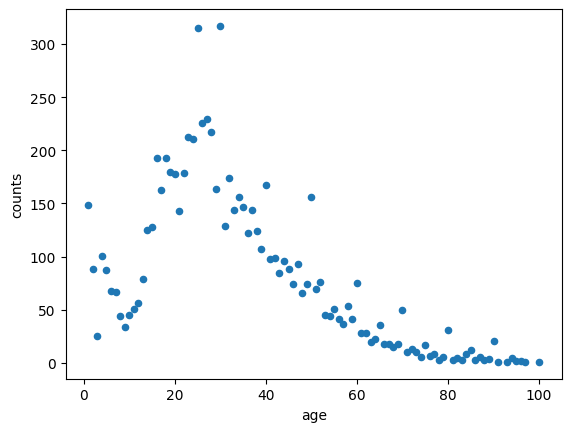

In [14]:
count_age.plot(kind='scatter', x='age', y='counts')

<AxesSubplot:>

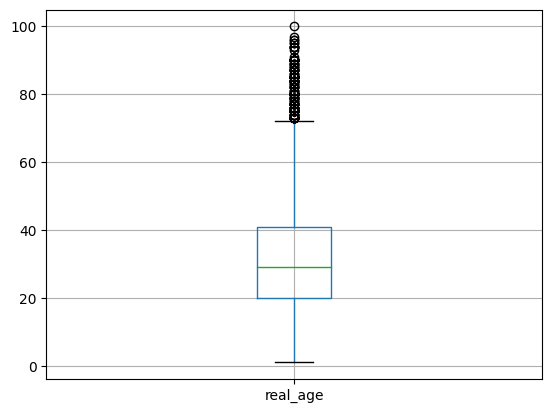

In [15]:
labels.boxplot(column=['real_age'])

### Findings

Based on the Exploratory Data Analysis (EDA) results, it was found that the most visited age group at the store consists of people who are nearly 30 years old. In the data description, it shows that the median age is 29, the mean age is 31, and the age group that shops the most is between the 20s and 30s. The histogram diagram also indicates that our data is skewed to the left or left-skewed. Therefore, the model might face some challenges in predicting the age of the oldest customers.

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

## Modelling 

Definisikan fungsi-fungsi yang diperlukan untuk melatih modelmu pada platform GPU dan buat satu skrip yang berisi semua fungsi tersebut beserta bagian inisialisasi.
Untuk mempermudah tugas ini, kamu bisa mendefinisikannya dalam notebook ini dan menjalankan kode siap pakai di bagian berikutnya untuk menyusun skrip secara otomatis.
Oh ya, definisi di bawah ini juga akan diperiksa oleh project reviewer agar mereka bisa memahami caramu membangun model.

In [ ]:
import pandas as pd

import tensorflow as tf

dari tensorflow.keras.preprocessing.image impor ImageDataGenerator
dari tensorflow.keras.applications.resnet impor ResNet50
dari tensorflow.keras.models impor Sequential
dari tensorflow.keras.layers impor GlobalAveragePooling2D, Dense, Dropout, Flatten
dari tensorflow.keras.optimizers impor Adam

In [16]:
def load_train(path):
    label = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255, horizontal_flip=True,vertical_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=label,
                                                       directory=path + 'final_files/',
                                                       x_col='file_name', 
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32, 
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=12345)

    return train_gen_flow

In [17]:
def load_test(path):
    label = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=label,
                                                     directory=path + 'final_files/',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=12345)

    return test_gen_flow

In [18]:
def create_model(input_shape):
    model=Sequential()
    optimizer=Adam(lr=0.0001)
    backbone = ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

In [19]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch == len(train_data)
    if validation_steps is None:
        validation_steps == len(test_data)
    model.fit(train_data,
             validation_data=test_data,
             batch_size=batch_size,
             epochs=epochs,
             steps_per_epoch=steps_per_epoch,
             validation_steps=validation_steps,
             verbose=2,
             shuffle=True)

    return model

## Script to run the code on the GPU platform

Setelah kamu mendefinisikan fungsi-fungsi yang diperlukan, kamu bisa membuat skrip untuk platform GPU, mengunduhnya melalui menu "File|Open...", dan mengunggahnya nanti untuk dijalankan pada platform GPU. "

Catatan: Skrip kamu juga harus menyertakan bagian inisialisasi. Contohnya ditunjukkan di bawah ini.

In [ ]:
init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Epoch 1/10 178/178 - 58s - loss: 311.7821 - mae: 12.6358 - val_loss: 404.5942 - val_mae: 15.1090

Epoch 2/10 178/178 - 38s - loss: 106.2193 - mae: 7.8094 - val_loss: 508.4560 - val_mae: 17.4513

Epoch 3/10 178/178 - 38s - loss: 85.3366 - mae: 6.9572 - val_loss: 236.9435 - val_mae: 12.1327

Epoch 4/10 178/178 - 38s - loss: 68.7039 - mae: 6.3010 - val_loss: 140.2855 - val_mae: 9.0605

Epoch 5/10 178/178 - 38s - loss: 54.7237 - mae: 5.6141 - val_loss: 82.4129 - val_mae: 6.8614

Epoch 6/10 178/178 - 38s - loss: 45.6390 - mae: 5.1376 - val_loss: 81.7789 - val_mae: 6.7122

Epoch 7/10 178/178 - 38s - loss: 39.1875 - mae: 4.7690 - val_loss: 85.7051 - val_mae: 7.2424

Epoch 8/10 178/178 - 38s - loss: 32.8471 - mae: 4.3474 - val_loss: 72.9251 - val_mae: 6.3738

Epoch 9/10 178/178 - 38s - loss: 29.6120 - mae: 4.1955 - val_loss: 77.1296 - val_mae: 6.6842

Epoch 10/10 178/178 - 38s - loss: 25.9009 - mae: 3.8958 - val_loss: 77.3979 - val_mae: 6.5742

60/60 - 9s - loss: 77.3979 - mae: 6.5742 Test MAE: 6.5742

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

## Summary

**EDA Conclusion:**

In the EDA section, it is observed that the most frequent shoppers are between the ages of 20 and 40.
The average age of visitors is 31 years old, and there are relatively few elderly visitors.

**Model Conclusion:**

The model we have created is a neural network model using the ResNet50 architecture. With 10 epochs and a single neuron, the model achieved an MAE (Mean Absolute Error) of 6.57. The expected value was below 7. Although there is a significant gap between the training set and validation set results, this might be due to overfitting, likely caused by the large number of layers in the model. However, this is not a major concern as it's a result of the model's complexity.

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

# Checklist

- [x]  Notebook dibuka 
- [x]  Tidak ada kesalahan dalam kode 
- [x]  Sel dengan kode telah disusun berdasarkan urutan eksekusi 
- [x]  Analisis data eksploratif telah dijalankan 
- [x]  Hasil dari analisis data eksploratif ditampilkan pada *notebook* final 
- [x]  Skor MAE model tidak lebih tinggi dari 8 
- [x]  Kode pelatihan model telah disalin ke notebook final 
- [x]  Output pelatihan model telah disalin di notebook final 
- [x]  Temuan telah diberikan berdasarkan hasil pelatihan model 